In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import tensorflow as tf
keras = tf.keras

2023-09-16 23:35:02.333193: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def plot_series(time,series,format="-",start=0,end=None,label=None):
    plt.plot(time[start:end], series[start:end],format,label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

    
def trend(time,slope=0):
    return slope*time
    
#seasonal Data
def seasonal_pattern(season_time):
    return np.where(season_time< 0.4,np.cos(season_time*2*np.pi),
                   1/np.exp(3*season_time))

def seasonality(time,period,amplitude=1,phase=0):
    season_time = ((time+phase)%period)/period
    return amplitude*seasonal_pattern(season_time)

# noise
def white_noise(time,noise_level=1,seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [3]:
time = np.arange(4*365+1)
slope = 0.05
baseline = 10
amplitude = 40

In [4]:
series = baseline+trend(time,slope)+seasonality(time,period=365,amplitude=amplitude)
noise_level = 5
noise = white_noise(time,noise_level,seed=42)
series += noise

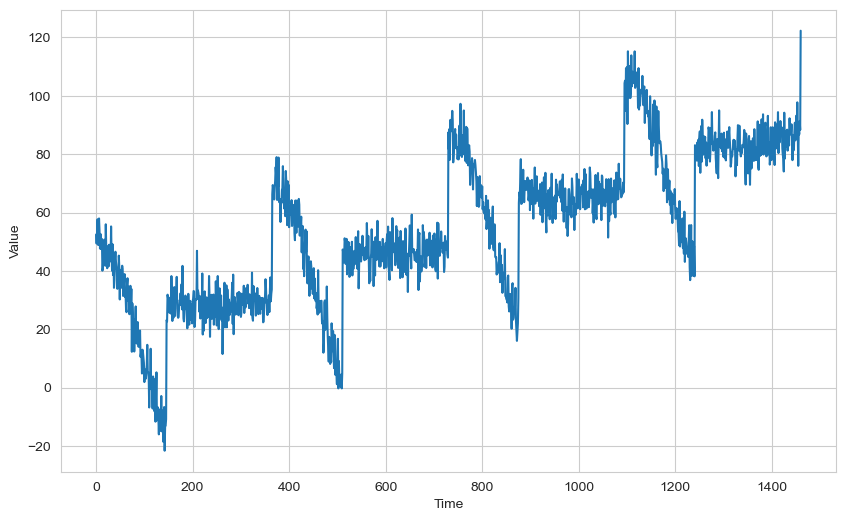

In [5]:
plt.figure(figsize=(10,6))
plot_series(time,series)
plt.show()

In [6]:
def window_dataset(series,window_size,batch_size=32,shuffle_buffer=100):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1,shift=1,drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window:(window[:-1],window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30

In [8]:
split_time = 1000
time_train = time[:split_time]
X_train = series[:split_time]
time_valid = time[split_time:]
X_valid = series[split_time:]

In [9]:
train_set = window_dataset(X_train,window_size,batch_size=128)

2023-09-16 23:36:10.351681: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
train_set

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [11]:
model = keras.models.Sequential([
    keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1),input_shape=[None]),
    keras.layers.SimpleRNN(100,return_sequences= True),
    keras.layers.SimpleRNN(100),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*200)
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 100)         10200     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100)               20100     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 30,401
Trainable params: 30,401
Non-trainable params: 0
_________________________________________________________________


In [13]:
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7*10**(epoch/20))

In [14]:
optimizer = keras.optimizers.SGD(learning_rate=1e-7,momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [15]:
history = model.fit(train_set,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 121ms/step - loss: 242.6806 - mae: 243.1806 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 0s 26ms/step - loss: 175.6076 - mae: 176.1076 - lr: 1.1220e-07
Epoch 3/100
8/8 [==============================] - 0s 26ms/step - loss: 95.7958 - mae: 96.2957 - lr: 1.2589e-07
Epoch 4/100
8/8 [==============================] - 0s 29ms/step - loss: 64.1880 - mae: 64.6873 - lr: 1.4125e-07
Epoch 5/100
8/8 [==============================] - 0s 34ms/step - loss: 53.9792 - mae: 54.4784 - lr: 1.5849e-07
Epoch 6/100
8/8 [==============================] - 0s 32ms/step - loss: 40.1259 - mae: 40.6230 - lr: 1.7783e-07
Epoch 7/100
8/8 [==============================] - 0s 34ms/step - loss: 33.4155 - mae: 33.9107 - lr: 1.9953e-07
Epoch 8/100
8/8 [==============================] - 0s 31ms/step - loss: 28.0523 - mae: 28.5468 - lr: 2.2387e-07
Epoch 9/100
8/8 [==============================] - 0s 33ms/step - loss: 19.3480 - mae: 19.8384 - lr

8/8 [==============================] - 0s 38ms/step - loss: 1210.9503 - mae: 1211.4503 - lr: 3.9811e-04
Epoch 74/100
8/8 [==============================] - 0s 36ms/step - loss: 1660.6698 - mae: 1661.1698 - lr: 4.4668e-04
Epoch 75/100
8/8 [==============================] - 0s 30ms/step - loss: 950.3854 - mae: 950.8854 - lr: 5.0119e-04
Epoch 76/100
8/8 [==============================] - 0s 28ms/step - loss: 2002.8083 - mae: 2003.3083 - lr: 5.6234e-04
Epoch 77/100
8/8 [==============================] - 0s 30ms/step - loss: 2119.6699 - mae: 2120.1697 - lr: 6.3096e-04
Epoch 78/100
8/8 [==============================] - 0s 31ms/step - loss: 4486.8540 - mae: 4487.3540 - lr: 7.0795e-04
Epoch 79/100
8/8 [==============================] - 0s 30ms/step - loss: 1723.0520 - mae: 1723.5520 - lr: 7.9433e-04
Epoch 80/100
8/8 [==============================] - 0s 33ms/step - loss: 2840.9893 - mae: 2841.4893 - lr: 8.9125e-04
Epoch 81/100
8/8 [==============================] - 0s 30ms/step - loss: 3637.0

(1e-07, 0.0001, 0.0, 30.0)

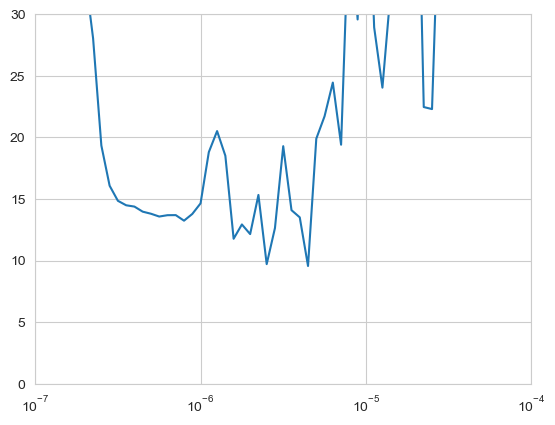

In [16]:
plt.semilogx(history.history['lr'],history.history['loss'])
plt.axis([1e-7,1e-4,0,30])

In [17]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30
train_set = window_dataset(X_train,window_size,batch_size=128)
valid_set = window_dataset(X_valid,window_size,batch_size=128)

In [18]:
model = keras.models.Sequential([
    keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1),input_shape=[None]),
    keras.layers.SimpleRNN(100,return_sequences=True),
    keras.layers.SimpleRNN(100),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0)
])

In [19]:
optimizer = keras.optimizers.SGD(learning_rate=1.5e-6,momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [20]:
early_stopping = keras.callbacks.EarlyStopping(patience=5)
model_checkpoint = keras.callbacks.ModelCheckpoint("my_checkpoint.h5",
                                                  save_best_only=True)

In [21]:
model.fit(train_set,epochs=500,
         validation_data=valid_set,
         callbacks=[early_stopping,model_checkpoint])

Epoch 1/500
8/8 [==============================] - 2s 105ms/step - loss: 72.3562 - mae: 72.8559 - val_loss: 23.2833 - val_mae: 23.7826
Epoch 2/500
8/8 [==============================] - 0s 40ms/step - loss: 38.8075 - mae: 39.3049 - val_loss: 56.9626 - val_mae: 57.4626
Epoch 3/500
8/8 [==============================] - 0s 54ms/step - loss: 45.2993 - mae: 45.7973 - val_loss: 10.5708 - val_mae: 11.0623
Epoch 4/500
8/8 [==============================] - 0s 49ms/step - loss: 37.0942 - mae: 37.5924 - val_loss: 13.1385 - val_mae: 13.6325
Epoch 5/500
8/8 [==============================] - 0s 46ms/step - loss: 50.1364 - mae: 50.6349 - val_loss: 49.8249 - val_mae: 50.3249
Epoch 6/500
8/8 [==============================] - 0s 43ms/step - loss: 19.4137 - mae: 19.9107 - val_loss: 26.3166 - val_mae: 26.8157
Epoch 7/500
8/8 [==============================] - 0s 46ms/step - loss: 12.0853 - mae: 12.5732 - val_loss: 12.1639 - val_mae: 12.6607
Epoch 8/500
8/8 [==============================] - 0s 41ms/st

In [22]:
model = keras.models.load_model("my_checkpoint.h5")

In [24]:
def model_forecast(model,series,window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size,shift=1,drop_remainder=True)
    ds = ds.flat_map(lambda w:w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [25]:
rnn_forecast = model_forcast(model,series[split_time-window_size:-1],window_size)[:,0]

15/15 [==============================] - 0s 9ms/step


11.00344

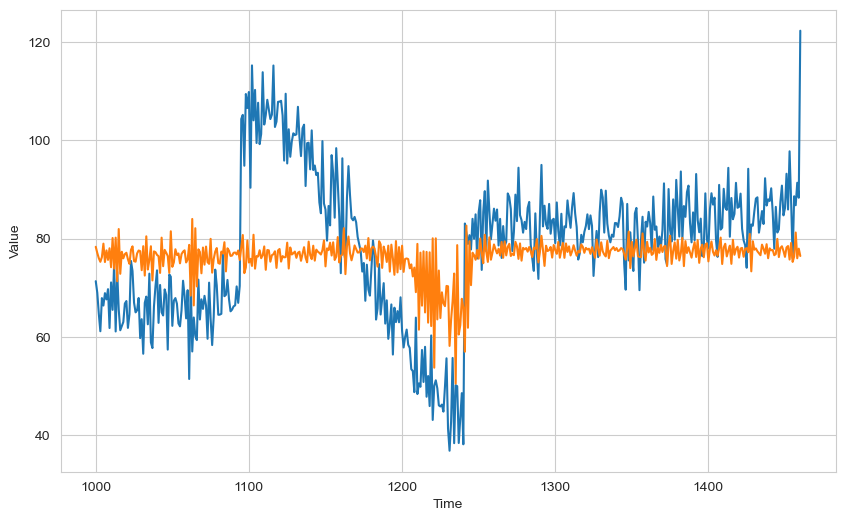

In [26]:
plt.figure(figsize=(10,6))
plot_series(time_valid,X_valid)
plot_series(time_valid,rnn_forecast)
print('\n')
keras.metrics.mean_absolute_error(X_valid,rnn_forecast).numpy()

### Sequence_to_Sequence

In [27]:
def seq2_seq_window_dataset(series,window_size,batch_size=32,shuffle_buffer=1000):
    series = tf.expand_dims(series,axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1,shift=1,drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size+1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1],w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [28]:
for X_batch,Y_batch in seq2_seq_window_dataset(tf.range(10),3,batch_size=1):
    print("X : ",X_batch.numpy())
    print("Y : ",Y_batch.numpy())

X :  [[[4]
  [5]
  [6]]]
Y :  [[[5]
  [6]
  [7]]]
X :  [[[1]
  [2]
  [3]]]
Y :  [[[2]
  [3]
  [4]]]
X :  [[[0]
  [1]
  [2]]]
Y :  [[[1]
  [2]
  [3]]]
X :  [[[5]
  [6]
  [7]]]
Y :  [[[6]
  [7]
  [8]]]
X :  [[[2]
  [3]
  [4]]]
Y :  [[[3]
  [4]
  [5]]]
X :  [[[6]
  [7]
  [8]]]
Y :  [[[7]
  [8]
  [9]]]
X :  [[[3]
  [4]
  [5]]]
Y :  [[[4]
  [5]
  [6]]]


In [29]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [30]:
window_size = 30
train_set = seq2_seq_window_dataset(X_train,window_size,batch_size=128)

In [31]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(100,return_sequences=True,input_shape=[None,1]),
    keras.layers.SimpleRNN(100,return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x:x*200)
])

In [32]:
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7*10**(epoch/30))

In [33]:
optimizer = keras.optimizers.SGD(learning_rate=1e-7,momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [34]:
history = model.fit(train_set,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 36ms/step - loss: 169.0744 - mae: 169.5743 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 0s 23ms/step - loss: 129.9188 - mae: 130.4188 - lr: 1.0798e-07
Epoch 3/100
8/8 [==============================] - 0s 24ms/step - loss: 71.6039 - mae: 72.1036 - lr: 1.1659e-07
Epoch 4/100
8/8 [==============================] - 0s 28ms/step - loss: 33.3212 - mae: 33.8170 - lr: 1.2589e-07
Epoch 5/100
8/8 [==============================] - 0s 28ms/step - loss: 34.9237 - mae: 35.4205 - lr: 1.3594e-07
Epoch 6/100
8/8 [==============================] - 0s 25ms/step - loss: 28.2820 - mae: 28.7769 - lr: 1.4678e-07
Epoch 7/100
8/8 [==============================] - 0s 27ms/step - loss: 25.1081 - mae: 25.5980 - lr: 1.5849e-07
Epoch 8/100
8/8 [==============================] - 0s 25ms/step - loss: 24.1204 - mae: 24.6101 - lr: 1.7113e-07
Epoch 9/100
8/8 [==============================] - 0s 25ms/step - loss: 23.4078 - mae: 23.8962 - lr:

Epoch 74/100
8/8 [==============================] - 0s 26ms/step - loss: 19.7843 - mae: 20.2825 - lr: 2.7123e-05
Epoch 75/100
8/8 [==============================] - 0s 23ms/step - loss: 20.5006 - mae: 20.9987 - lr: 2.9286e-05
Epoch 76/100
8/8 [==============================] - 0s 23ms/step - loss: 21.3324 - mae: 21.8303 - lr: 3.1623e-05
Epoch 77/100
8/8 [==============================] - 0s 24ms/step - loss: 23.0522 - mae: 23.5503 - lr: 3.4145e-05
Epoch 78/100
8/8 [==============================] - 0s 25ms/step - loss: 24.7880 - mae: 25.2871 - lr: 3.6869e-05
Epoch 79/100
8/8 [==============================] - 0s 23ms/step - loss: 26.7919 - mae: 27.2890 - lr: 3.9811e-05
Epoch 80/100
8/8 [==============================] - 0s 24ms/step - loss: 69.6626 - mae: 70.1605 - lr: 4.2987e-05
Epoch 81/100
8/8 [==============================] - 0s 24ms/step - loss: 107.4492 - mae: 107.9481 - lr: 4.6416e-05
Epoch 82/100
8/8 [==============================] - 0s 25ms/step - loss: 49.1348 - mae: 49.632

(1e-07, 0.0001, 0.0, 30.0)

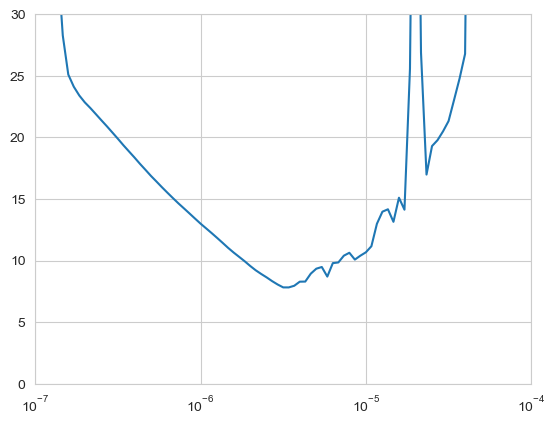

In [35]:
plt.semilogx(history.history['lr'],history.history["loss"])
plt.axis([1e-7,1e-4,0,30])

In [36]:
#second
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [37]:
window_size = 30
train_set = seq2_seq_window_dataset(X_train,window_size,batch_size=128)
valid_set = seq2_seq_window_dataset(X_valid,window_size,batch_size=128)

In [38]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(100,return_sequences=True,input_shape=[None,1]),
    keras.layers.SimpleRNN(100,return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x:x*200)
])

In [39]:
optimizer = keras.optimizers.SGD(learning_rate=1e-6,momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [40]:
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set,epochs=500,
         validation_data=valid_set,
         callbacks=[early_stopping])

Epoch 1/500
8/8 [==============================] - 2s 110ms/step - loss: 85.2917 - mae: 85.7907 - val_loss: 50.9326 - val_mae: 51.4324
Epoch 2/500
8/8 [==============================] - 0s 40ms/step - loss: 54.1961 - mae: 54.6946 - val_loss: 78.1698 - val_mae: 78.6696
Epoch 3/500
8/8 [==============================] - 0s 39ms/step - loss: 37.6539 - mae: 38.1510 - val_loss: 21.6902 - val_mae: 22.1852
Epoch 4/500
8/8 [==============================] - 0s 43ms/step - loss: 26.6245 - mae: 27.1193 - val_loss: 18.0349 - val_mae: 18.5295
Epoch 5/500
8/8 [==============================] - 0s 41ms/step - loss: 22.7437 - mae: 23.2372 - val_loss: 21.7914 - val_mae: 22.2884
Epoch 6/500
8/8 [==============================] - 0s 40ms/step - loss: 18.6594 - mae: 19.1500 - val_loss: 18.5183 - val_mae: 19.0137
Epoch 7/500
8/8 [==============================] - 0s 41ms/step - loss: 16.4787 - mae: 16.9681 - val_loss: 14.5529 - val_mae: 15.0449
Epoch 8/500
8/8 [==============================] - 0s 37ms/st

8/8 [==============================] - 0s 39ms/step - loss: 5.9834 - mae: 6.4621 - val_loss: 5.8508 - val_mae: 6.3308
Epoch 64/500
8/8 [==============================] - 0s 48ms/step - loss: 5.9635 - mae: 6.4427 - val_loss: 6.0180 - val_mae: 6.4989
Epoch 65/500
8/8 [==============================] - 1s 50ms/step - loss: 5.9550 - mae: 6.4336 - val_loss: 5.6994 - val_mae: 6.1803
Epoch 66/500
8/8 [==============================] - 0s 43ms/step - loss: 5.9266 - mae: 6.4054 - val_loss: 5.8923 - val_mae: 6.3723
Epoch 67/500
8/8 [==============================] - 0s 36ms/step - loss: 5.9068 - mae: 6.3856 - val_loss: 5.8941 - val_mae: 6.3743
Epoch 68/500
8/8 [==============================] - 0s 36ms/step - loss: 5.8934 - mae: 6.3721 - val_loss: 5.7567 - val_mae: 6.2365
Epoch 69/500
8/8 [==============================] - 0s 37ms/step - loss: 5.8685 - mae: 6.3470 - val_loss: 5.8496 - val_mae: 6.3295
Epoch 70/500
8/8 [==============================] - 0s 36ms/step - loss: 5.8534 - mae: 6.3320 - 

In [41]:
rnn_forecast = model_forcast(model,series[...,np.newaxis],window_size)

45/45 [==============================] - 1s 6ms/step


In [42]:
rnn_forecast = rnn_forecast[split_time-window_size:-1,-1,0]

5.423652




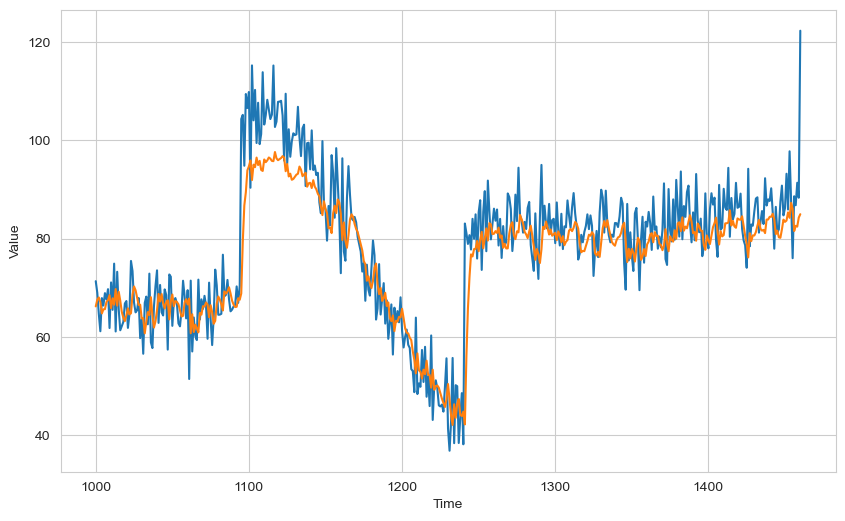

In [43]:
print(keras.metrics.mean_absolute_error(X_valid,rnn_forecast).numpy())
print('\n')
plt.figure(figsize=(10,6))
plot_series(time_valid,X_valid)
plot_series(time_valid,rnn_forecast)

### StateFull RNN

In [44]:
def sequential_window_dataset(series,window_size):
    series = tf.expand_dims(series,axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1,shift=window_size,drop_remainder=True)
    ds = ds.flat_map(lambda window:window.batch(window_size+1))
    ds = ds.map(lambda window:(window[:-1],window[1:]))
    return ds.batch(1).prefetch(1)

In [45]:
for X_batch,Y_batch in sequential_window_dataset(tf.range(10),3):
    print(X_batch.numpy(),Y_batch.numpy())

[[[0]
  [1]
  [2]]] [[[1]
  [2]
  [3]]]
[[[3]
  [4]
  [5]]] [[[4]
  [5]
  [6]]]
[[[6]
  [7]
  [8]]] [[[7]
  [8]
  [9]]]


In [46]:
class RestStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self,epoch,logs):
        self.model.reset_states()

In [47]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [48]:
window_size = 30
train_set = sequential_window_dataset(X_train,window_size)

In [49]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(100,return_sequences=True,stateful=True,batch_input_shape=[1,None,1]),
    keras.layers.SimpleRNN(100,return_sequences=True,stateful=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*200.0)
])

In [50]:
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8*10**(epoch/30))

In [51]:
reset_states = RestStatesCallback()

In [52]:
optimizer = keras.optimizers.SGD(learning_rate=1e-8,momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [53]:
history = model.fit(train_set,epochs=100,
                   callbacks=[lr_schedule,reset_states])

Epoch 1/100
33/33 [==============================] - 1s 9ms/step - loss: 71.8540 - mae: 72.3529 - lr: 1.0000e-08
Epoch 2/100
33/33 [==============================] - 0s 7ms/step - loss: 42.7170 - mae: 43.2147 - lr: 1.0798e-08
Epoch 3/100
33/33 [==============================] - 0s 7ms/step - loss: 36.0449 - mae: 36.5387 - lr: 1.1659e-08
Epoch 4/100
33/33 [==============================] - 0s 6ms/step - loss: 28.4813 - mae: 28.9705 - lr: 1.2589e-08
Epoch 5/100
33/33 [==============================] - 0s 7ms/step - loss: 25.0422 - mae: 25.5304 - lr: 1.3594e-08
Epoch 6/100
33/33 [==============================] - 0s 7ms/step - loss: 23.5809 - mae: 24.0672 - lr: 1.4678e-08
Epoch 7/100
33/33 [==============================] - 0s 6ms/step - loss: 23.0207 - mae: 23.5104 - lr: 1.5849e-08
Epoch 8/100
33/33 [==============================] - 0s 7ms/step - loss: 22.6142 - mae: 23.1043 - lr: 1.7113e-08
Epoch 9/100
33/33 [==============================] - 0s 7ms/step - loss: 22.2456 - mae: 22.7350 

Epoch 73/100
33/33 [==============================] - 0s 6ms/step - loss: 23.1189 - mae: 23.6145 - lr: 2.5119e-06
Epoch 74/100
33/33 [==============================] - 0s 6ms/step - loss: 14.1314 - mae: 14.6238 - lr: 2.7123e-06
Epoch 75/100
33/33 [==============================] - 0s 7ms/step - loss: 20.9542 - mae: 21.4500 - lr: 2.9286e-06
Epoch 76/100
33/33 [==============================] - 0s 6ms/step - loss: 22.6100 - mae: 23.1050 - lr: 3.1623e-06
Epoch 77/100
33/33 [==============================] - 0s 6ms/step - loss: 19.4962 - mae: 19.9904 - lr: 3.4145e-06
Epoch 78/100
33/33 [==============================] - 0s 7ms/step - loss: 11.5938 - mae: 12.0868 - lr: 3.6869e-06
Epoch 79/100
33/33 [==============================] - 0s 7ms/step - loss: 19.6983 - mae: 20.1939 - lr: 3.9811e-06
Epoch 80/100
33/33 [==============================] - 0s 7ms/step - loss: 16.4081 - mae: 16.8981 - lr: 4.2987e-06
Epoch 81/100
33/33 [==============================] - 0s 7ms/step - loss: 18.0550 - mae:

In [54]:
#model = keras.models.load_model("my_checkpoint.h5")
#model.reset_states()

In [55]:
model.reset_states()
rnn_forecast = model.predict(series[np.newaxis, : ,np.newaxis])
rnn_forecast = rnn_forecast[0, split_time -1 :-1, 0]

1/1 [==============================] - 0s 318ms/step


In [56]:
rnn_forecast.shape

(461,)

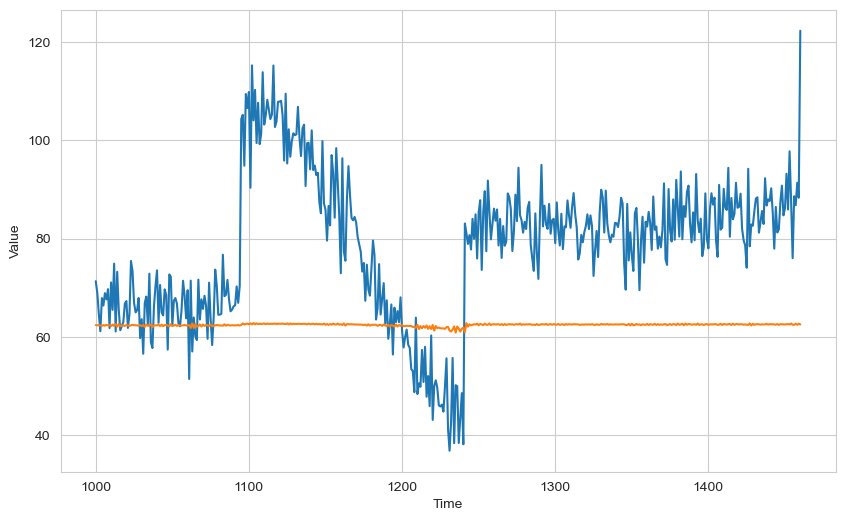

In [57]:
plt.figure(figsize=(10,6))
plot_series(time_valid,X_valid)
plot_series(time_valid,rnn_forecast)